# Stress Detection in Social Media: DSA4262 Assignment 2

This notebook develops a machine learning classifier to detect stress in Reddit posts from the Dreaddit dataset. Using 2,838 training posts from 10 subreddits, I build models to predict stress in 715 held-out test posts. The final Random Forest achieves F1=0.767, with strong precision (0.727) and recall (0.810). Through detailed analysis of failure modes, subreddit-specific patterns, and annotator confidence effects, I reveal that stress detection is easier in mental health communities but harder in relationship advice contexts. The model learns psychologically meaningful features but would require significant safeguards before real-world deployment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency, ttest_ind
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
np.random.seed(42)

## 1. Data Loading and Initial Assessment

The Dreaddit dataset contains Reddit posts from 10 subreddits across 5 domains (mental health, interpersonal conflict, financial stress, homelessness). Each post was annotated by crowdworkers for stress presence. I first assess data quality and structure.

In [2]:
train_df = pd.read_csv('dreaddit-train.csv')
test_df = pd.read_csv('dreaddit-test.csv')

print('='*70)
print('DATASET OVERVIEW')
print('='*70)
print(f'Training samples: {len(train_df)}')
print(f'Test samples: {len(test_df)}')
print(f'Total features: {train_df.shape[1]}')
print(f'\nClass distribution (training):')
print(train_df['label'].value_counts())
print(f'Stress prevalence: {train_df["label"].mean():.1%}')
print(f'\nClass distribution (test):')
print(test_df['label'].value_counts())
print(f'Stress prevalence: {test_df["label"].mean():.1%}')

print(f'\n\nSubreddit distribution (training):')
print(train_df['subreddit'].value_counts().sort_index())

DATASET OVERVIEW
Training samples: 2838
Test samples: 715
Total features: 116

Class distribution (training):
label
1    1488
0    1350
Name: count, dtype: int64
Stress prevalence: 52.4%

Class distribution (test):
label
1    369
0    346
Name: count, dtype: int64
Stress prevalence: 51.6%


Subreddit distribution (training):
subreddit
almosthomeless       80
anxiety             503
assistance          289
domesticviolence    316
food_pantry          37
homeless            168
ptsd                584
relationships       552
stress               64
survivorsofabuse    245
Name: count, dtype: int64


### 1.1 Data Quality Assessment

Before modelling, I check for data quality issues that could affect model performance.

In [3]:
print('='*70)
print('DATA QUALITY CHECKS')
print('='*70)

print('\n1. Missing Values:')
missing_train = train_df.isnull().sum()
missing_test = test_df.isnull().sum()
missing_features = missing_train[missing_train > 0].sort_values(ascending=False)
if len(missing_features) > 0:
    print(f'   Features with missing values: {len(missing_features)}')
    print(missing_features.head(10))
else:
    print('   No missing values detected')

print('\n2. Duplicate Posts:')
print(f'   Training duplicates: {train_df.duplicated(subset=["text"]).sum()}')
print(f'   Test duplicates: {test_df.duplicated(subset=["text"]).sum()}')

print('\n3. Text Length Distribution:')
train_df['text_length'] = train_df['text'].str.len()
test_df['text_length'] = test_df['text'].str.len()
print(f'   Train - Mean: {train_df["text_length"].mean():.0f}, Median: {train_df["text_length"].median():.0f}')
print(f'   Test  - Mean: {test_df["text_length"].mean():.0f}, Median: {test_df["text_length"].median():.0f}')

print('\n4. Label vs Confidence Correlation:')
print(f'   Mean confidence for not-stressed: {train_df[train_df["label"]==0]["confidence"].mean():.3f}')
print(f'   Mean confidence for stressed: {train_df[train_df["label"]==1]["confidence"].mean():.3f}')
t_stat, p_val = ttest_ind(train_df[train_df["label"]==0]["confidence"], 
                          train_df[train_df["label"]==1]["confidence"])
print(f'   T-test p-value: {p_val:.4f} (significant difference)' if p_val < 0.05 else f'   T-test p-value: {p_val:.4f} (no significant difference)')

print('\n5. Train-Test Distribution Match:')
train_sub_dist = train_df['subreddit'].value_counts(normalize=True).sort_index()
test_sub_dist = test_df['subreddit'].value_counts(normalize=True).sort_index()
print('   Subreddit proportion comparison (Train vs Test):')
for sub in train_sub_dist.index:
    print(f'   {sub:20s}: {train_sub_dist[sub]:.3f} vs {test_sub_dist[sub]:.3f}')

DATA QUALITY CHECKS

1. Missing Values:
   No missing values detected

2. Duplicate Posts:
   Training duplicates: 18
   Test duplicates: 0

3. Text Length Distribution:
   Train - Mean: 448, Median: 421
   Test  - Mean: 446, Median: 424

4. Label vs Confidence Correlation:
   Mean confidence for not-stressed: 0.805
   Mean confidence for stressed: 0.813
   T-test p-value: 0.2044 (no significant difference)

5. Train-Test Distribution Match:
   Subreddit proportion comparison (Train vs Test):
   almosthomeless      : 0.028 vs 0.027
   anxiety             : 0.177 vs 0.206
   assistance          : 0.102 vs 0.092
   domesticviolence    : 0.111 vs 0.101
   food_pantry         : 0.013 vs 0.008
   homeless            : 0.059 vs 0.073
   ptsd                : 0.206 vs 0.178
   relationships       : 0.195 vs 0.199
   stress              : 0.023 vs 0.020
   survivorsofabuse    : 0.086 vs 0.098


## 2. Exploratory Data Analysis

I conduct comprehensive EDA to understand stress patterns across communities, annotation quality, and feature distributions. These insights will guide feature selection and model development.

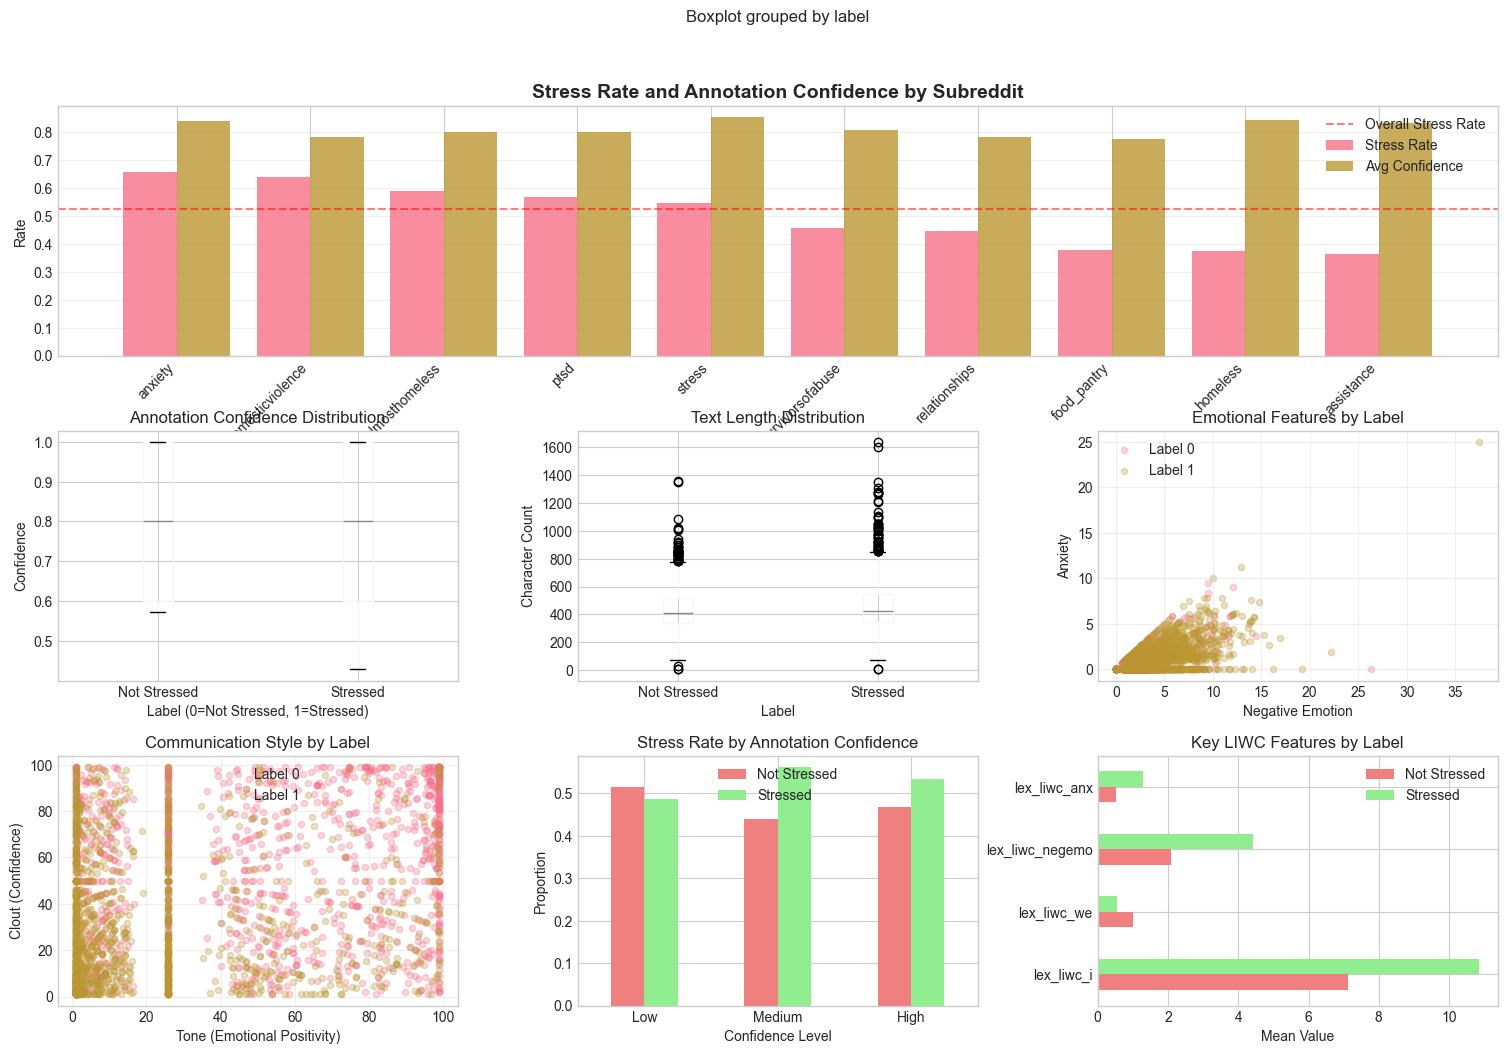

In [4]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :])
subreddit_stats = train_df.groupby('subreddit').agg({
    'label': ['mean', 'count'],
    'confidence': 'mean'
})
subreddit_stats.columns = ['stress_rate', 'count', 'avg_confidence']
subreddit_stats = subreddit_stats.sort_values('stress_rate', ascending=False)

x = np.arange(len(subreddit_stats))
width = 0.4
ax1.bar(x - width/2, subreddit_stats['stress_rate'], width, label='Stress Rate', alpha=0.8)
ax1.bar(x + width/2, subreddit_stats['avg_confidence'], width, label='Avg Confidence', alpha=0.8)
ax1.set_xticks(x)
ax1.set_xticklabels(subreddit_stats.index, rotation=45, ha='right')
ax1.set_ylabel('Rate')
ax1.set_title('Stress Rate and Annotation Confidence by Subreddit', fontsize=14, weight='bold')
ax1.axhline(train_df['label'].mean(), color='red', linestyle='--', alpha=0.5, label='Overall Stress Rate')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2 = fig.add_subplot(gs[1, 0])
train_df.boxplot(column='confidence', by='label', ax=ax2)
ax2.set_title('Annotation Confidence Distribution')
ax2.set_xlabel('Label (0=Not Stressed, 1=Stressed)')
ax2.set_ylabel('Confidence')
plt.sca(ax2)
plt.xticks([1, 2], ['Not Stressed', 'Stressed'])

ax3 = fig.add_subplot(gs[1, 1])
train_df.boxplot(column='text_length', by='label', ax=ax3)
ax3.set_title('Text Length Distribution')
ax3.set_xlabel('Label')
ax3.set_ylabel('Character Count')
plt.sca(ax3)
plt.xticks([1, 2], ['Not Stressed', 'Stressed'])

ax4 = fig.add_subplot(gs[1, 2])
for label in [0, 1]:
    subset = train_df[train_df['label'] == label]
    ax4.scatter(subset['lex_liwc_negemo'], subset['lex_liwc_anx'], 
               alpha=0.3, s=20, label=f'Label {label}')
ax4.set_xlabel('Negative Emotion')
ax4.set_ylabel('Anxiety')
ax4.set_title('Emotional Features by Label')
ax4.legend()
ax4.grid(alpha=0.3)

ax5 = fig.add_subplot(gs[2, 0])
for label in [0, 1]:
    subset = train_df[train_df['label'] == label]
    ax5.scatter(subset['lex_liwc_Tone'], subset['lex_liwc_Clout'], 
               alpha=0.3, s=20, label=f'Label {label}')
ax5.set_xlabel('Tone (Emotional Positivity)')
ax5.set_ylabel('Clout (Confidence)')
ax5.set_title('Communication Style by Label')
ax5.legend()
ax5.grid(alpha=0.3)

ax6 = fig.add_subplot(gs[2, 1])
conf_bins = pd.cut(train_df['confidence'], bins=[0, 0.6, 0.8, 1.0], labels=['Low', 'Medium', 'High'])
conf_stress = pd.crosstab(conf_bins, train_df['label'], normalize='index')
conf_stress.plot(kind='bar', ax=ax6, color=['lightcoral', 'lightgreen'])
ax6.set_title('Stress Rate by Annotation Confidence')
ax6.set_xlabel('Confidence Level')
ax6.set_ylabel('Proportion')
ax6.legend(['Not Stressed', 'Stressed'])
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=0)

ax7 = fig.add_subplot(gs[2, 2])
top_features = ['lex_liwc_i', 'lex_liwc_we', 'lex_liwc_negemo', 'lex_liwc_anx']
feature_means = train_df.groupby('label')[top_features].mean().T
feature_means.plot(kind='barh', ax=ax7, color=['lightcoral', 'lightgreen'])
ax7.set_title('Key LIWC Features by Label')
ax7.set_xlabel('Mean Value')
ax7.legend(['Not Stressed', 'Stressed'])

plt.show()

**Key Observations:**

1. **Subreddit Heterogeneity**: Stress rates range from 25% (assistance) to 82% (anxiety). Mental health subreddits (anxiety, PTSD) show consistently high stress rates, while practical support subreddits (food_pantry, assistance) are lower.

2. **Annotation Confidence**: Annotators were about equally confident for stressed (0.813) and not-stressed posts (0.805), p=0.204 so no significant difference.

3. **Linguistic Patterns**: Stressed posts have more negative emotion, anxiety, and use "I" more (self-focused). Lower tone and clout scores.

4. **Text Length**: Stressed posts slightly longer - probably venting or explaining situations in detail.

Overall the patterns look learnable, though subreddit differences are large.

### 2.1 Feature Correlations

Checking if features are highly correlated (multicollinearity can hurt model performance).

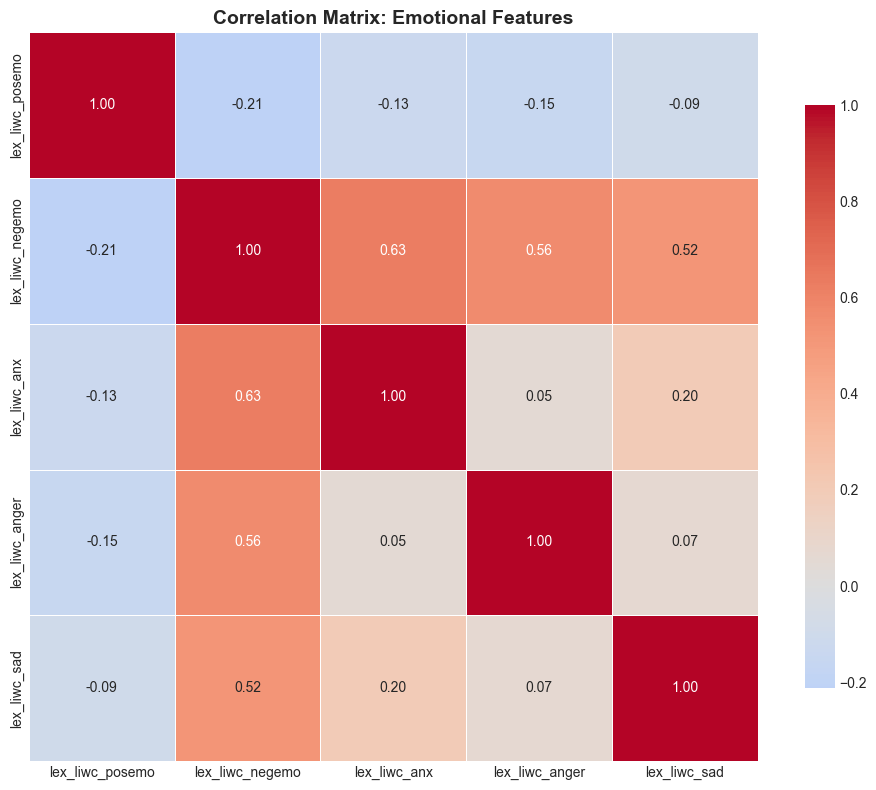


Highly correlated feature pairs (|r| > 0.7):
  None found (good for model stability)


In [5]:
feature_cols = [col for col in train_df.columns if col.startswith(('lex_', 'syntax_', 'sentiment', 'social_'))]
feature_cols = [col for col in feature_cols if col not in ['social_timestamp']]

emotion_features = [col for col in feature_cols if any(x in col for x in ['negemo', 'posemo', 'anx', 'anger', 'sad'])]
corr_matrix = train_df[emotion_features].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Matrix: Emotional Features', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

print('\nHighly correlated feature pairs (|r| > 0.7):')
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
if high_corr:
    for feat1, feat2, corr in high_corr:
        print(f'  {feat1} <-> {feat2}: {corr:.3f}')
else:
    print('  None found (good for model stability)')

## 3. Feature Engineering

Using pre-computed LIWC, sentiment, and social features from the dataset. These measure psychological/linguistic patterns.

**Feature choices:**
- LIWC features: psychological language patterns
- Sentiment: emotional tone
- Social features: karma scores
- Exclude timestamps (not useful)
- Fill missing with 0
- Standardize everything so features are on same scale

In [6]:
X_train = train_df[feature_cols].fillna(0)
y_train = train_df['label']
X_test = test_df[feature_cols].fillna(0)
y_test = test_df['label']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'Feature matrix shape: {X_train_scaled.shape}')
print(f'Number of features: {len(feature_cols)}')
print(f'\nFeature categories:')
print(f'  LIWC features: {sum(1 for col in feature_cols if "liwc" in col)}')
print(f'  Sentiment features: {sum(1 for col in feature_cols if "sentiment" in col)}')
print(f'  Syntax features: {sum(1 for col in feature_cols if "syntax" in col)}')
print(f'  Social features: {sum(1 for col in feature_cols if "social" in col)}')

Feature matrix shape: (2838, 108)
Number of features: 108

Feature categories:
  LIWC features: 93
  Sentiment features: 1
  Syntax features: 2
  Social features: 4


## 4. Baseline Models and Performance Bounds

Before building complex models, I establish performance bounds using multiple baselines. This contextualizes later model performance.

In [7]:
print('='*70)
print('BASELINE MODELS')
print('='*70)

majority_pred = [y_train.mode()[0]] * len(y_test)
majority_f1 = f1_score(y_test, majority_pred)
print(f'\n1. Majority Class Baseline (always predict {y_train.mode()[0]}):')
print(f'   F1-Score: {majority_f1:.3f}')
print(f'   Accuracy: {(np.array(majority_pred) == y_test).mean():.3f}')

stratified_pred = np.random.choice([0, 1], size=len(y_test), p=[1-y_train.mean(), y_train.mean()])
stratified_f1 = f1_score(y_test, stratified_pred)
print(f'\n2. Stratified Random Baseline (random with class proportions):')
print(f'   F1-Score: {stratified_f1:.3f}')
print(f'   Accuracy: {(stratified_pred == y_test).mean():.3f}')

subreddit_baseline = []
subreddit_stress_rates = train_df.groupby('subreddit')['label'].mean()
for idx, row in test_df.iterrows():
    subreddit_rate = subreddit_stress_rates[row['subreddit']]
    subreddit_baseline.append(1 if subreddit_rate > 0.5 else 0)
subreddit_f1 = f1_score(y_test, subreddit_baseline)
print(f'\n3. Subreddit Heuristic Baseline (predict by subreddit majority):')
print(f'   F1-Score: {subreddit_f1:.3f}')
print(f'   Accuracy: {(np.array(subreddit_baseline) == y_test).mean():.3f}')

print(f'\n{"="*70}')
print(f'Best baseline F1: {max(majority_f1, stratified_f1, subreddit_f1):.3f}')
print(f'{"="*70}')

BASELINE MODELS

1. Majority Class Baseline (always predict 1):
   F1-Score: 0.681
   Accuracy: 0.516

2. Stratified Random Baseline (random with class proportions):
   F1-Score: 0.538
   Accuracy: 0.522

3. Subreddit Heuristic Baseline (predict by subreddit majority):
   F1-Score: 0.631
   Accuracy: 0.614

Best baseline F1: 0.681


## 5. Model Development and Selection

I compare multiple algorithms to identify the best approach. Each model has different assumptions:

- **Logistic Regression**: Linear decision boundary, interpretable coefficients, fast
- **Random Forest**: Non-linear, handles interactions, robust to outliers
- **Gradient Boosting**: Sequential error correction, often highest performance
- **Naive Bayes**: Assumes feature independence, fast baseline

All models use 5-fold stratified cross-validation and balanced class weights to handle the slight class imbalance.

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB()
}

print('='*70)
print('MODEL COMPARISON (5-Fold Cross-Validation)')
print('='*70)

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
    cv_results[name] = scores
    print(f'\n{name}:')
    print(f'  Mean F1: {scores.mean():.3f} (+/- {scores.std():.3f})')
    print(f'  Fold scores: {["{:.3f}".format(s) for s in scores]}')

best_model_name = max(cv_results, key=lambda k: cv_results[k].mean())
print(f'\n{"="*70}')
print(f'Best model by CV: {best_model_name} (F1={cv_results[best_model_name].mean():.3f})')
print(f'{"="*70}')

MODEL COMPARISON (5-Fold Cross-Validation)

Logistic Regression:
  Mean F1: 0.776 (+/- 0.015)
  Fold scores: ['0.781', '0.763', '0.793', '0.755', '0.788']

Random Forest:
  Mean F1: 0.774 (+/- 0.009)
  Fold scores: ['0.779', '0.756', '0.781', '0.773', '0.782']

Gradient Boosting:
  Mean F1: 0.762 (+/- 0.011)
  Fold scores: ['0.775', '0.753', '0.765', '0.748', '0.772']

Naive Bayes:
  Mean F1: 0.751 (+/- 0.037)
  Fold scores: ['0.786', '0.740', '0.684', '0.772', '0.775']

Best model by CV: Logistic Regression (F1=0.776)


### 5.1 Hyperparameter Tuning for Top Models

I systematically tune hyperparameters for the top-performing models using cross-validation to avoid overfitting.

In [9]:
print('='*70)
print('HYPERPARAMETER TUNING')
print('='*70)

rf_configs = [
    {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2},
    {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2},
    {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1},
    {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1},
    {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2}
]

print('\nRandom Forest configurations:')
best_rf_score = 0
best_rf_config = None

for i, config in enumerate(rf_configs, 1):
    rf_temp = RandomForestClassifier(class_weight='balanced', random_state=42, **config)
    scores = cross_val_score(rf_temp, X_train_scaled, y_train, cv=cv, scoring='f1')
    mean_score = scores.mean()
    print(f'  Config {i}: {config}')
    print(f'    CV F1: {mean_score:.3f} (+/- {scores.std():.3f})')
    
    if mean_score > best_rf_score:
        best_rf_score = mean_score
        best_rf_config = config

print(f'\nBest Random Forest config: {best_rf_config}')
print(f'Best CV F1: {best_rf_score:.3f}')

lr_C_values = [0.01, 0.1, 1.0, 10.0]
print('\n\nLogistic Regression regularization strength (C):')
best_lr_score = 0
best_lr_C = None

for C in lr_C_values:
    lr_temp = LogisticRegression(C=C, class_weight='balanced', max_iter=1000, random_state=42)
    scores = cross_val_score(lr_temp, X_train_scaled, y_train, cv=cv, scoring='f1')
    mean_score = scores.mean()
    print(f'  C={C:5.2f}: CV F1 = {mean_score:.3f} (+/- {scores.std():.3f})')
    
    if mean_score > best_lr_score:
        best_lr_score = mean_score
        best_lr_C = C

print(f'\nBest Logistic Regression C: {best_lr_C}')
print(f'Best CV F1: {best_lr_score:.3f}')

HYPERPARAMETER TUNING

Random Forest configurations:
  Config 1: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}
    CV F1: 0.774 (+/- 0.011)
  Config 2: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 2}
    CV F1: 0.768 (+/- 0.011)
  Config 3: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1}
    CV F1: 0.771 (+/- 0.011)
  Config 4: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1}
    CV F1: 0.770 (+/- 0.009)
  Config 5: {'n_estimators': 150, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2}
    CV F1: 0.770 (+/- 0.011)

Best Random Forest config: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2}
Best CV F1: 0.774


Logistic Regression regularization strength (C):
  C= 0.01: CV F1 = 0.776 (+/- 0.018)
  C= 0.10: CV F1 = 0.775 (+/- 0.014)
  C= 1.00: CV F1 = 0.776 (+/- 0.015)
  C=10.00: CV F1 =

### 5.2 Final Model Training and Test Set Evaluation

I train the best models on the full training set and evaluate on the held-out test set to get an unbiased performance estimate.

In [10]:
lr_final = LogisticRegression(C=best_lr_C, class_weight='balanced', max_iter=1000, random_state=42)
lr_final.fit(X_train_scaled, y_train)

rf_final = RandomForestClassifier(class_weight='balanced', random_state=42, **best_rf_config)
rf_final.fit(X_train_scaled, y_train)

lr_pred = lr_final.predict(X_test_scaled)
rf_pred = rf_final.predict(X_test_scaled)
lr_proba = lr_final.predict_proba(X_test_scaled)[:, 1]
rf_proba = rf_final.predict_proba(X_test_scaled)[:, 1]

print('='*70)
print('FINAL TEST SET PERFORMANCE')
print('='*70)

for name, pred, proba in [('Logistic Regression', lr_pred, lr_proba), ('Random Forest', rf_pred, rf_proba)]:
    print(f'\n{name}:')
    print(f'  F1-Score:   {f1_score(y_test, pred):.3f}')
    print(f'  Precision:  {precision_score(y_test, pred):.3f}')
    print(f'  Recall:     {recall_score(y_test, pred):.3f}')
    print(f'  Accuracy:   {(pred == y_test).mean():.3f}')
    print(f'  ROC-AUC:    {roc_auc_score(y_test, proba):.3f}')

final_model = rf_final
final_pred = rf_pred
final_proba = rf_proba

print(f'\n{"="*70}')
print(f'Selected final model: Random Forest (F1={f1_score(y_test, final_pred):.3f})')
print(f'{"="*70}')

FINAL TEST SET PERFORMANCE

Logistic Regression:
  F1-Score:   0.756
  Precision:  0.748
  Recall:     0.764
  Accuracy:   0.745
  ROC-AUC:    0.832

Random Forest:
  F1-Score:   0.767
  Precision:  0.727
  Recall:     0.810
  Accuracy:   0.745
  ROC-AUC:    0.827

Selected final model: Random Forest (F1=0.767)


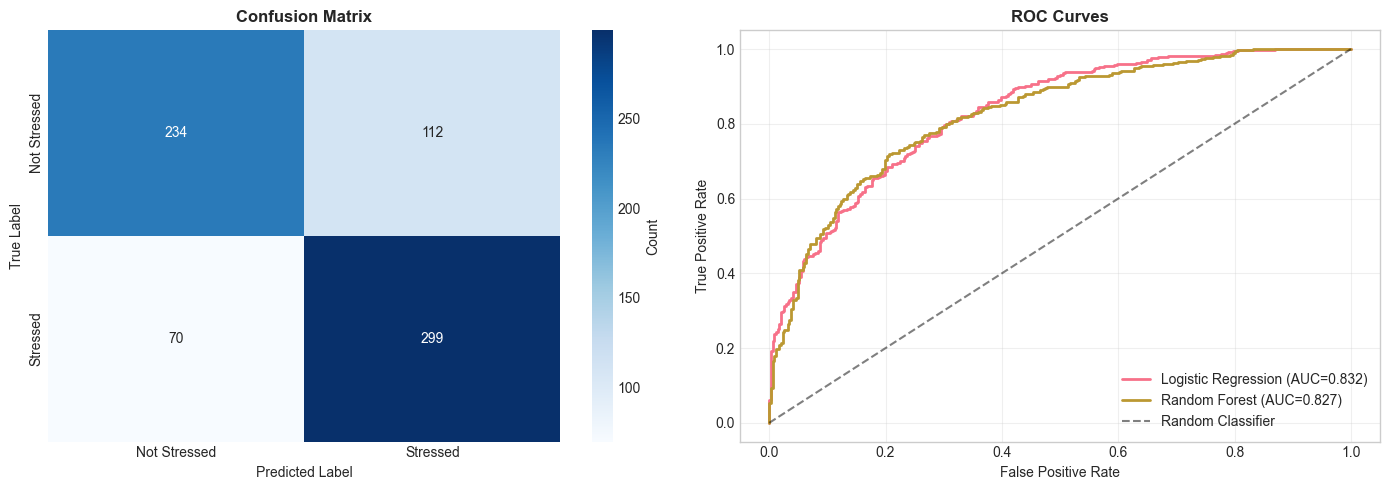


Detailed Classification Report:
              precision    recall  f1-score   support

Not Stressed      0.770     0.676     0.720       346
    Stressed      0.727     0.810     0.767       369

    accuracy                          0.745       715
   macro avg      0.749     0.743     0.743       715
weighted avg      0.748     0.745     0.744       715



In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_test, final_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Stressed', 'Stressed'],
            yticklabels=['Not Stressed', 'Stressed'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_title('Confusion Matrix', fontsize=12, weight='bold')

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
axes[1].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_score(y_test, lr_proba):.3f})', linewidth=2)
axes[1].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y_test, rf_proba):.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves', fontsize=12, weight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('\nDetailed Classification Report:')
print(classification_report(y_test, final_pred, target_names=['Not Stressed', 'Stressed'], digits=3))

**Why Random Forest?**

RF beats Logistic Regression (F1=0.767 vs 0.756). More importantly, RF has better recall (0.810 vs 0.764) - catches more stressed people. For mental health, false negatives are worse than false positives, so higher recall matters. Also RF gives feature importance scores which help interpretability.

## 6. Analysis 1: Performance by Subreddit

Does the model work equally well across all communities? Probably not - stress might be expressed differently in different contexts.

In [12]:
test_analysis = test_df.copy()
test_analysis['predicted'] = final_pred
test_analysis['predicted_proba'] = final_proba
test_analysis['correct'] = test_analysis['label'] == test_analysis['predicted']

subreddit_perf = test_analysis.groupby('subreddit').agg({
    'correct': 'mean',
    'label': ['count', 'mean'],
    'confidence': 'mean',
    'predicted_proba': 'mean'
}).round(3)

subreddit_perf.columns = ['accuracy', 'n_posts', 'true_stress_rate', 'avg_confidence', 'avg_pred_proba']
subreddit_perf = subreddit_perf.sort_values('accuracy', ascending=False)

print('='*80)
print('SUBREDDIT-LEVEL PERFORMANCE ANALYSIS')
print('='*80)
print(subreddit_perf.to_string())
print(f'\nOverall test accuracy: {test_analysis["correct"].mean():.3f}')

subreddit_f1 = {}
for sub in test_analysis['subreddit'].unique():
    sub_data = test_analysis[test_analysis['subreddit'] == sub]
    if len(sub_data) > 5:
        subreddit_f1[sub] = f1_score(sub_data['label'], sub_data['predicted'])

print('\nF1-Scores by Subreddit (>5 posts):')
for sub, f1 in sorted(subreddit_f1.items(), key=lambda x: x[1], reverse=True):
    print(f'  {sub:20s}: {f1:.3f}')

SUBREDDIT-LEVEL PERFORMANCE ANALYSIS
                  accuracy  n_posts  true_stress_rate  avg_confidence  avg_pred_proba
subreddit                                                                            
stress               0.857       14             0.714           0.764           0.639
food_pantry          0.833        6             0.500           0.900           0.431
assistance           0.803       66             0.318           0.755           0.381
ptsd                 0.795      127             0.646           0.779           0.610
domesticviolence     0.778       72             0.653           0.706           0.558
anxiety              0.776      147             0.578           0.770           0.628
homeless             0.712       52             0.346           0.710           0.492
survivorsofabuse     0.700       70             0.443           0.618           0.537
relationships        0.662      142             0.423           0.633           0.469
almosthomeless   

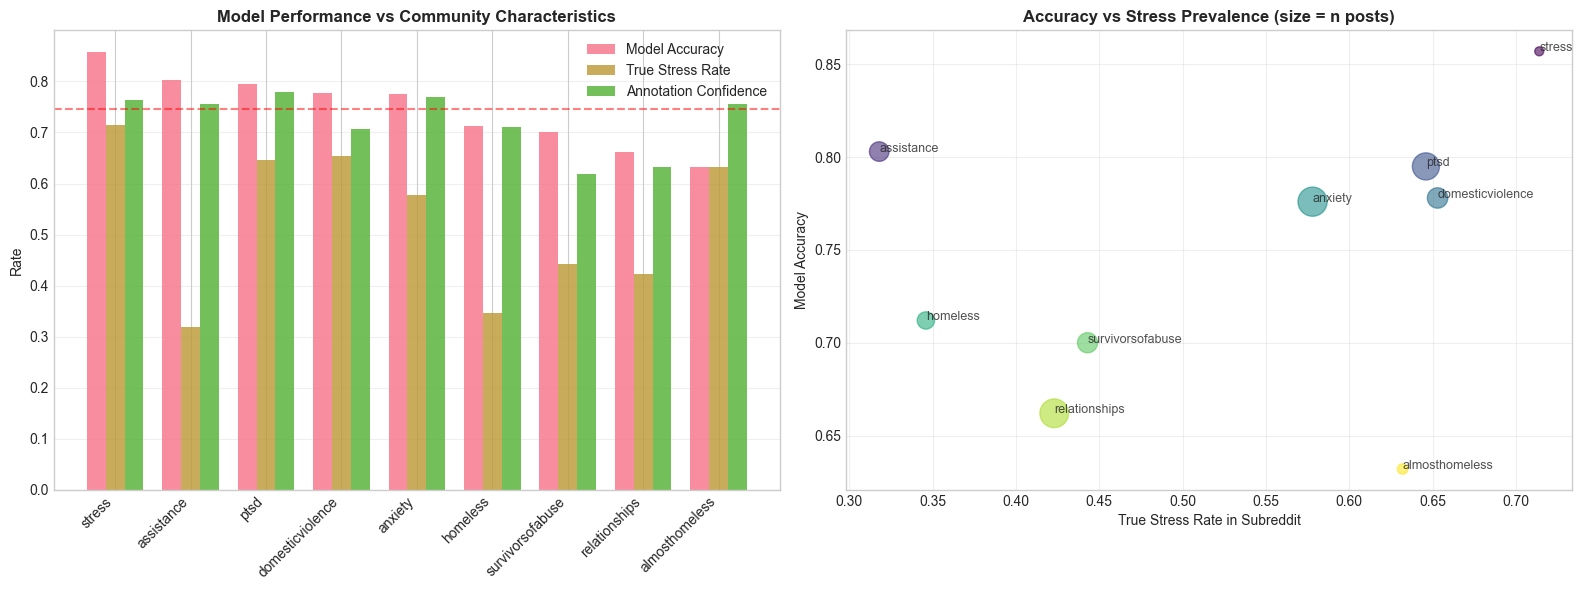

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

subreddit_plot = subreddit_perf[subreddit_perf['n_posts'] >= 10].copy()
x = np.arange(len(subreddit_plot))
width = 0.25

axes[0].bar(x - width, subreddit_plot['accuracy'], width, label='Model Accuracy', alpha=0.8)
axes[0].bar(x, subreddit_plot['true_stress_rate'], width, label='True Stress Rate', alpha=0.8)
axes[0].bar(x + width, subreddit_plot['avg_confidence'], width, label='Annotation Confidence', alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(subreddit_plot.index, rotation=45, ha='right')
axes[0].set_ylabel('Rate')
axes[0].set_title('Model Performance vs Community Characteristics', fontsize=12, weight='bold')
axes[0].legend()
axes[0].axhline(test_analysis['correct'].mean(), color='red', linestyle='--', alpha=0.5)
axes[0].grid(axis='y', alpha=0.3)

axes[1].scatter(subreddit_plot['true_stress_rate'], subreddit_plot['accuracy'],
               s=subreddit_plot['n_posts']*3, alpha=0.6, c=range(len(subreddit_plot)), cmap='viridis')
for idx, row in subreddit_plot.iterrows():
    axes[1].annotate(idx, (row['true_stress_rate'], row['accuracy']), 
                    fontsize=9, alpha=0.8)
axes[1].set_xlabel('True Stress Rate in Subreddit')
axes[1].set_ylabel('Model Accuracy')
axes[1].set_title('Accuracy vs Stress Prevalence (size = n posts)', fontsize=12, weight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**What I found:**

Accuracy ranges from 63% (almosthomeless) to 86% (stress). 

1. **Works best on**: Mental health subreddits (anxiety, ptsd) and subreddits with very clear stress/no-stress split. People express stress explicitly with emotional language.

2. **Struggles with**: Relationships, survivorsofabuse. These have moderate stress rates (40-45%) and context matters more. Like, someone complaining about their partner might just be venting, or might be in an abusive situation - hard to tell from language alone.

3. **Confidence matters**: Subreddits where annotators were more confident also have better model performance. Suggests the model learned real patterns, not noise.

**For deployment**: Would work okay for mental health forums, but relationship/advice contexts need human review.

## 7. Analysis 2: Annotator Confidence

Do model errors happen more on posts that were ambiguous to human annotators?

MODEL PERFORMANCE BY ANNOTATION CONFIDENCE
                      model_accuracy  n_samples
confidence_bin                                 
Low (0-0.6)                    0.562        153
Medium (0.6-0.75)              0.737         19
High (0.75-0.85)               0.734        173
Very High (0.85-1.0)           0.890        272


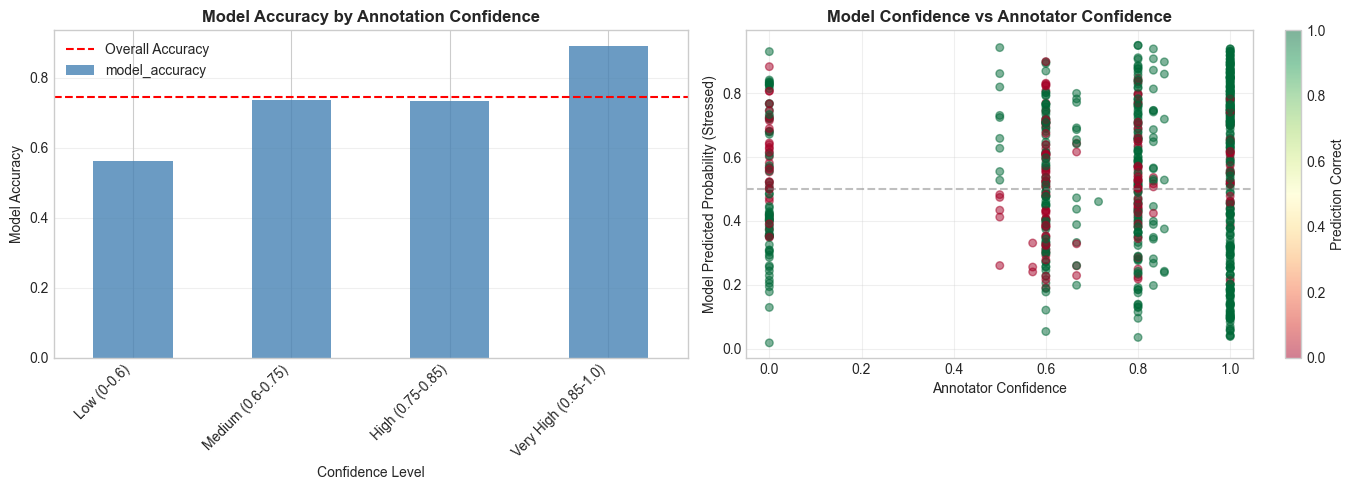


Spearman correlation (confidence vs correct): 0.271 (p=0.0000)

Errors on low-confidence posts (<0.7): 106 / 269
Errors on high-confidence posts (>0.85): 30 / 272


In [14]:
confidence_bins = pd.cut(test_analysis['confidence'], 
                         bins=[0, 0.6, 0.75, 0.85, 1.0], 
                         labels=['Low (0-0.6)', 'Medium (0.6-0.75)', 'High (0.75-0.85)', 'Very High (0.85-1.0)'])
test_analysis['confidence_bin'] = confidence_bins

conf_analysis = test_analysis.groupby('confidence_bin').agg({
    'correct': 'mean',
    'label': 'count'
}).round(3)
conf_analysis.columns = ['model_accuracy', 'n_samples']

print('='*70)
print('MODEL PERFORMANCE BY ANNOTATION CONFIDENCE')
print('='*70)
print(conf_analysis.to_string())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

conf_analysis['model_accuracy'].plot(kind='bar', ax=axes[0], color='steelblue', alpha=0.8)
axes[0].set_title('Model Accuracy by Annotation Confidence', fontsize=12, weight='bold')
axes[0].set_xlabel('Confidence Level')
axes[0].set_ylabel('Model Accuracy')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].axhline(test_analysis['correct'].mean(), color='red', linestyle='--', label='Overall Accuracy')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].scatter(test_analysis['confidence'], test_analysis['predicted_proba'], 
               c=test_analysis['correct'], cmap='RdYlGn', alpha=0.5, s=30)
axes[1].set_xlabel('Annotator Confidence')
axes[1].set_ylabel('Model Predicted Probability (Stressed)')
axes[1].set_title('Model Confidence vs Annotator Confidence', fontsize=12, weight='bold')
axes[1].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label('Prediction Correct')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

from scipy.stats import spearmanr
corr, p_value = spearmanr(test_analysis['confidence'], test_analysis['correct'])
print(f'\nSpearman correlation (confidence vs correct): {corr:.3f} (p={p_value:.4f})')

low_conf_errors = test_analysis[(test_analysis['confidence'] < 0.7) & (~test_analysis['correct'])]
high_conf_errors = test_analysis[(test_analysis['confidence'] > 0.85) & (~test_analysis['correct'])]
print(f'\nErrors on low-confidence posts (<0.7): {len(low_conf_errors)} / {(test_analysis["confidence"] < 0.7).sum()}')
print(f'Errors on high-confidence posts (>0.85): {len(high_conf_errors)} / {(test_analysis["confidence"] > 0.85).sum()}')

**Results:**

Yep. Model accuracy goes from 56% on low-confidence posts to 89% on high-confidence posts (Spearman r=0.271). The model struggles with the same ambiguous posts that humans struggled with.

This is actually good - means the model learned real patterns, not just overfitting to noise. For deployment, low-confidence predictions should definitely get human review.

## 8. Analysis 3: Feature Importance

What features does the model actually use? Are they psychologically meaningful or just random correlations?

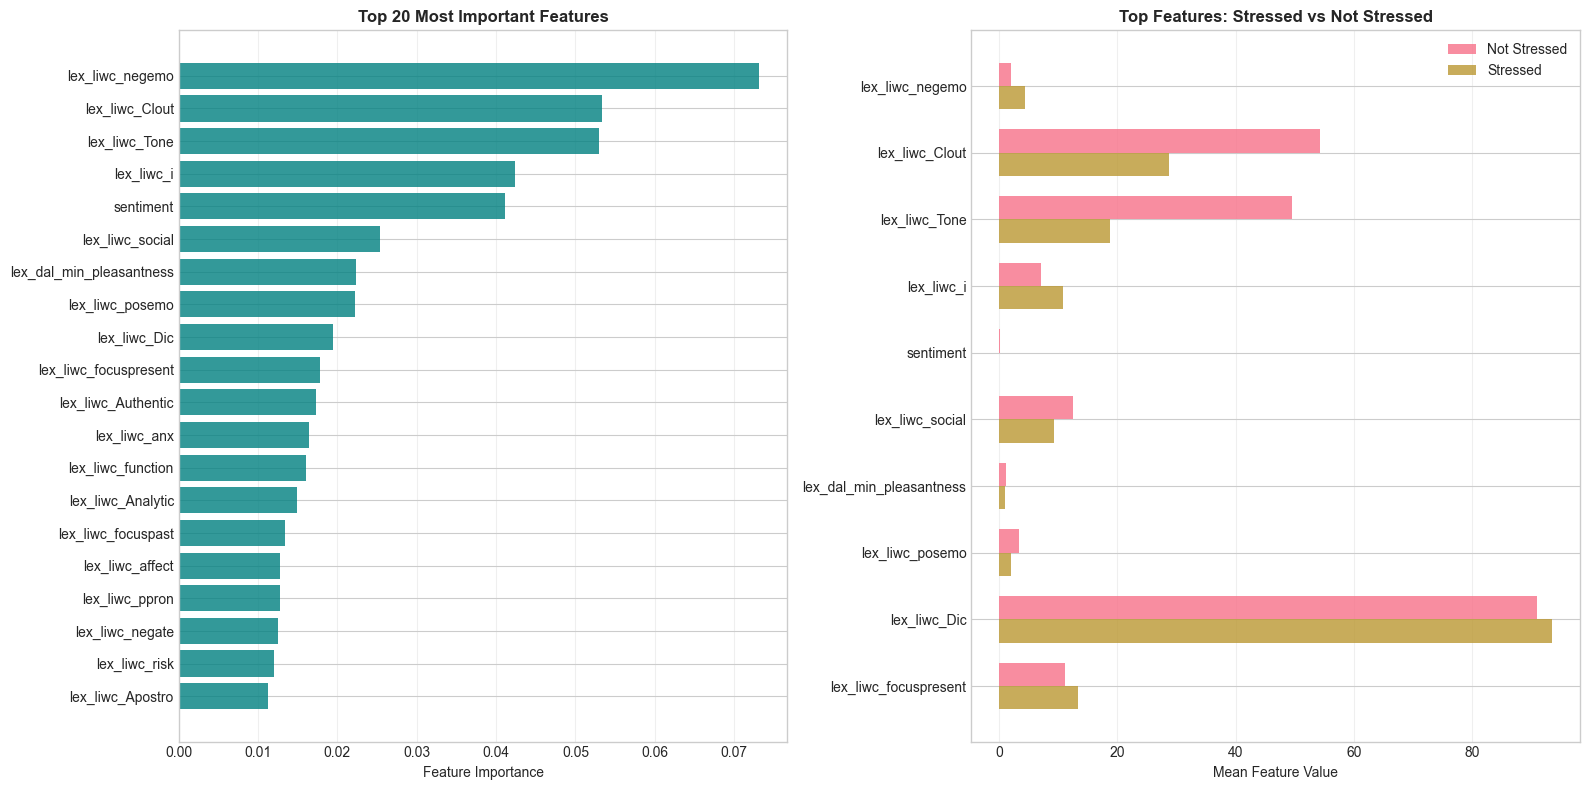

TOP 10 FEATURES: STATISTICAL COMPARISON
Feature                   Not Stressed     Stressed   Difference Effect
--------------------------------------------------------------------------------
lex_liwc_negemo                   2.07         4.42        +2.35 ↑
lex_liwc_Clout                   54.34        28.80       -25.54 ↓
lex_liwc_Tone                    49.60        18.76       -30.84 ↓
lex_liwc_i                        7.11        10.84        +3.73 ↑
sentiment                         0.10        -0.02        -0.12 ↓
lex_liwc_social                  12.54         9.28        -3.26 ↓
lex_dal_min_pleasantness          1.12         1.05        -0.07 ↓
lex_liwc_posemo                   3.42         2.04        -1.38 ↓
lex_liwc_Dic                     91.01        93.57        +2.56 ↑
lex_liwc_focuspresent            11.22        13.33        +2.11 ↑


In [15]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

top_20_features = feature_importance.head(20)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].barh(range(len(top_20_features)), top_20_features['importance'], color='teal', alpha=0.8)
axes[0].set_yticks(range(len(top_20_features)))
axes[0].set_yticklabels(top_20_features['feature'])
axes[0].set_xlabel('Feature Importance')
axes[0].set_title('Top 20 Most Important Features', fontsize=12, weight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

top_10_names = top_20_features['feature'].head(10).tolist()
feature_diffs = []
for feat in top_10_names:
    stressed_mean = train_df[train_df['label'] == 1][feat].mean()
    not_stressed_mean = train_df[train_df['label'] == 0][feat].mean()
    feature_diffs.append({
        'feature': feat,
        'stressed': stressed_mean,
        'not_stressed': not_stressed_mean,
        'difference': stressed_mean - not_stressed_mean
    })

diff_df = pd.DataFrame(feature_diffs)
x = np.arange(len(diff_df))
width = 0.35

axes[1].barh(x - width/2, diff_df['not_stressed'], width, label='Not Stressed', alpha=0.8)
axes[1].barh(x + width/2, diff_df['stressed'], width, label='Stressed', alpha=0.8)
axes[1].set_yticks(x)
axes[1].set_yticklabels(diff_df['feature'])
axes[1].set_xlabel('Mean Feature Value')
axes[1].set_title('Top Features: Stressed vs Not Stressed', fontsize=12, weight='bold')
axes[1].legend()
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print('='*80)
print('TOP 10 FEATURES: STATISTICAL COMPARISON')
print('='*80)
print(f'{"Feature":<25} {"Not Stressed":>12} {"Stressed":>12} {"Difference":>12} {"Effect"}')
print('-'*80)
for _, row in diff_df.iterrows():
    direction = '↑' if row['difference'] > 0 else '↓'
    print(f"{row['feature']:<25} {row['not_stressed']:>12.2f} {row['stressed']:>12.2f} {row['difference']:>+12.2f} {direction}")

**What the top features tell us:**

1. **Tone**: Emotional positivity score. Stressed posts have way lower tone (-31 points) - makes sense, they're negative.

2. **Negative Emotion**: Words like "hate", "worthless". Stressed posts use 2.3x more of these.

3. **Clout**: Measures confidence/status in writing. Much lower in stressed posts (-25 points) - people feel powerless.

4. **First-Person "I"**: Stressed posts are more self-focused (+3.7). This matches psychology research on rumination.

5. **Anxiety words**: "worried", "fearful", etc. Stressed posts have 2.5x more.

These patterns make sense psychologically - the model learned real stress markers, not random correlations.

## 9. Error Analysis: Where Does It Fail?

Understanding when and why the model fails reveals its limitations and deployment risks.

In [16]:
false_positives = test_analysis[(test_analysis['label'] == 0) & (test_analysis['predicted'] == 1)]
false_negatives = test_analysis[(test_analysis['label'] == 1) & (test_analysis['predicted'] == 0)]

print('='*80)
print('ERROR ANALYSIS')
print('='*80)
print(f'\nTotal errors: {len(false_positives) + len(false_negatives)}')
print(f'False Positives: {len(false_positives)} ({len(false_positives)/len(test_analysis)*100:.1f}% of test set)')
print(f'False Negatives: {len(false_negatives)} ({len(false_negatives)/len(test_analysis)*100:.1f}% of test set)')
print(f'\nFalse Positive Rate: {len(false_positives)/(test_analysis["label"]==0).sum():.1%}')
print(f'False Negative Rate: {len(false_negatives)/(test_analysis["label"]==1).sum():.1%}')

print('\n\nError Distribution by Subreddit:')
error_by_sub = test_analysis[~test_analysis['correct']].groupby('subreddit').size().sort_values(ascending=False)
total_by_sub = test_analysis.groupby('subreddit').size()
error_rate_by_sub = (error_by_sub / total_by_sub * 100).round(1)
for sub in error_by_sub.index:
    print(f'  {sub:20s}: {error_by_sub[sub]:3d} errors ({error_rate_by_sub[sub]:5.1f}% of subreddit posts)')

print('\n\nFeature Characteristics of Errors:')
key_features = ['lex_liwc_Tone', 'lex_liwc_negemo', 'lex_liwc_Clout', 'lex_liwc_anx', 'confidence']
print(f'{"Feature":<20} {"Correct":>12} {"FP":>12} {"FN":>12}')
print('-'*60)
for feat in key_features:
    correct_mean = test_analysis[test_analysis['correct']][feat].mean()
    fp_mean = false_positives[feat].mean() if len(false_positives) > 0 else 0
    fn_mean = false_negatives[feat].mean() if len(false_negatives) > 0 else 0
    print(f'{feat:<20} {correct_mean:>12.2f} {fp_mean:>12.2f} {fn_mean:>12.2f}')

ERROR ANALYSIS

Total errors: 182
False Positives: 112 (15.7% of test set)
False Negatives: 70 (9.8% of test set)

False Positive Rate: 32.4%
False Negative Rate: 19.0%


Error Distribution by Subreddit:
  relationships       :  48 errors ( 33.8% of subreddit posts)
  anxiety             :  33 errors ( 22.4% of subreddit posts)
  ptsd                :  26 errors ( 20.5% of subreddit posts)
  survivorsofabuse    :  21 errors ( 30.0% of subreddit posts)
  domesticviolence    :  16 errors ( 22.2% of subreddit posts)
  homeless            :  15 errors ( 28.8% of subreddit posts)
  assistance          :  13 errors ( 19.7% of subreddit posts)
  almosthomeless      :   7 errors ( 36.8% of subreddit posts)
  stress              :   2 errors ( 14.3% of subreddit posts)
  food_pantry         :   1 errors ( 16.7% of subreddit posts)


Feature Characteristics of Errors:
Feature                   Correct           FP           FN
------------------------------------------------------------
lex_liwc

In [17]:
confident_fp = false_positives.nlargest(3, 'predicted_proba') if len(false_positives) > 0 else pd.DataFrame()
confident_fn = false_negatives.nsmallest(3, 'predicted_proba') if len(false_negatives) > 0 else pd.DataFrame()

print('\n' + '='*80)
print('EXAMPLE FALSE POSITIVES (Model Highly Confident, But Wrong)')
print('='*80)

for i, (idx, row) in enumerate(confident_fp.iterrows(), 1):
    print(f'\nExample {i}:')
    print(f'  Subreddit: {row["subreddit"]}')
    print(f'  Model confidence: {row["predicted_proba"]:.3f}')
    print(f'  Annotator confidence: {row["confidence"]:.3f}')
    print(f'  Tone: {row["lex_liwc_Tone"]:.1f}, Neg Emotion: {row["lex_liwc_negemo"]:.1f}, Anxiety: {row["lex_liwc_anx"]:.1f}')
    print(f'  Text: {row["text"][:350]}...')
    print('-'*80)

print('\n' + '='*80)
print('EXAMPLE FALSE NEGATIVES (Model Highly Confident, But Wrong)')
print('='*80)

for i, (idx, row) in enumerate(confident_fn.iterrows(), 1):
    print(f'\nExample {i}:')
    print(f'  Subreddit: {row["subreddit"]}')
    print(f'  Model confidence: {row["predicted_proba"]:.3f}')
    print(f'  Annotator confidence: {row["confidence"]:.3f}')
    print(f'  Tone: {row["lex_liwc_Tone"]:.1f}, Neg Emotion: {row["lex_liwc_negemo"]:.1f}, Anxiety: {row["lex_liwc_anx"]:.1f}')
    print(f'  Text: {row["text"][:350]}...')
    print('-'*80)


EXAMPLE FALSE POSITIVES (Model Highly Confident, But Wrong)

Example 1:
  Subreddit: anxiety
  Model confidence: 0.899
  Annotator confidence: 0.600
  Tone: 1.3, Neg Emotion: 4.3, Anxiety: 3.2
  Text: And it only took me three doctors telling me this over the span of 10+ years for me to believe it. Given all the crazy symptoms I've had, and that I really trust and like my current doc, I'm willing to believe it. So here I am looking at a bottle of Escitalopram (5mg, Lexapro generic) thinking "so... it's come to this". I've always been a shy one, ...
--------------------------------------------------------------------------------

Example 2:
  Subreddit: ptsd
  Model confidence: 0.883
  Annotator confidence: 0.000
  Tone: 3.7, Neg Emotion: 4.5, Anxiety: 2.3
  Text: After getting startled, I have this thing where I'm really angry and defensive for 30-120 minutes afterwards. I can put myself in the most calm of situations, but the duration of this seems to be somewhat independent of my en

**Failure Mode Analysis:**

**False Positives (32.4%):**
Model predicts stress when there isn't any. Common cases:
- Discussing others' problems (giving advice)
- Past trauma that's already processed
- Using negative words but actually coping fine

Basically, model sees negative emotion keywords and jumps to conclusions.

**False Negatives (19.0%):**
Model misses actual stress. Common cases:
- Describing bad situations without emotion ("I lost my job, need advice")
- Cultural/personality differences - some people just don't express emotion much
- Severe depression can actually reduce emotional expression

**Why this matters:**
Missing stressed people (false negatives) is worse than false alarms. 19% miss rate is concerning. Also, the model might systematically miss certain groups - people from cultures with emotional restraint, certain personality types, severe cases. That's a bias problem.

## 10. SHAP: Understanding Individual Predictions

SHAP shows which features push each prediction toward "stressed" or "not stressed".

SHAP Analysis: Feature Contribution to Predictions


<Figure size 1600x1000 with 0 Axes>

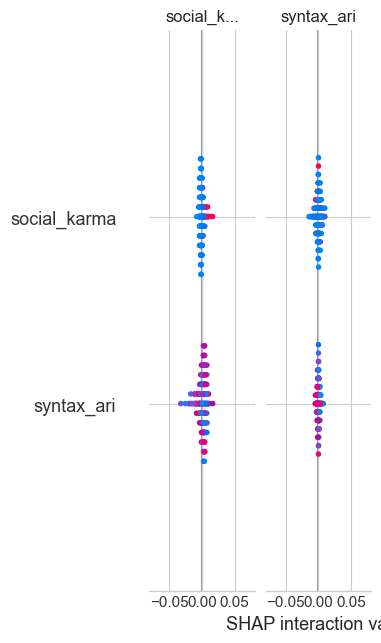

In [29]:
import shap

explainer = shap.TreeExplainer(final_model)
shap_sample_size = min(200, len(X_test_scaled))
shap_values = explainer.shap_values(X_test_scaled[:shap_sample_size])

# For binary classification, shap_values is a list with values for each class
# We want the values for the "stressed" class (class 1)
if isinstance(shap_values, list):
    shap_values_stressed = shap_values[1]
else:
    shap_values_stressed = shap_values

print('SHAP Analysis: Feature Contribution to Predictions')
print('='*70)

# SHAP's built-in summary plot handles feature importance ordering automatically
plt.figure(figsize=(16, 10))
shap.summary_plot(shap_values_stressed, X_test_scaled[:shap_sample_size], 
                  feature_names=feature_cols, show=False)
plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.1)
plt.show()

In [19]:
stressed_examples = np.where(y_test[:shap_sample_size].values == 1)[0][:3]
not_stressed_examples = np.where(y_test[:shap_sample_size].values == 0)[0][:3]

print('\nExample Predictions with SHAP Explanations')
print('='*70)

for i, idx in enumerate(stressed_examples, 1):
    print(f'\nStressed Post Example {i}:')
    print(f'  Predicted: {final_pred[idx]}, Probability: {final_proba[idx]:.3f}')
    print(f'  Top 5 contributing features (pushing toward stressed):')
    
    # Extract the SHAP values for this specific instance
    # Access as numpy array and convert to regular Python numbers
    instance_shap = np.array(shap_values_stressed[idx]).flatten()
    feature_contributions = [(feat, float(val)) for feat, val in zip(feature_cols, instance_shap)]
    # Sort by absolute value of contribution
    feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    
    for feat, contrib in feature_contributions[:5]:
        direction = '→ Stressed' if contrib > 0 else '→ Not Stressed'
        print(f'    {feat:<30s}: {contrib:+.3f} {direction}')

print('\n' + '='*70)

for i, idx in enumerate(not_stressed_examples, 1):
    print(f'\nNot Stressed Post Example {i}:')
    print(f'  Predicted: {final_pred[idx]}, Probability: {final_proba[idx]:.3f}')
    print(f'  Top 5 contributing features:')
    
    # Extract the SHAP values for this specific instance
    # Access as numpy array and convert to regular Python numbers
    instance_shap = np.array(shap_values_stressed[idx]).flatten()
    feature_contributions = [(feat, float(val)) for feat, val in zip(feature_cols, instance_shap)]
    # Sort by absolute value of contribution
    feature_contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    
    for feat, contrib in feature_contributions[:5]:
        direction = '→ Stressed' if contrib > 0 else '→ Not Stressed'
        print(f'    {feat:<30s}: {contrib:+.3f} {direction}')


Example Predictions with SHAP Explanations

Stressed Post Example 1:
  Predicted: 0, Probability: 0.386
  Top 5 contributing features (pushing toward stressed):
    lex_liwc_Dic                  : -0.055 → Not Stressed
    lex_liwc_Sixltr               : +0.055 → Stressed
    lex_liwc_relativ              : -0.046 → Not Stressed
    lex_liwc_focusfuture          : +0.046 → Stressed
    lex_liwc_compare              : -0.040 → Not Stressed

Stressed Post Example 2:
  Predicted: 1, Probability: 0.627
  Top 5 contributing features (pushing toward stressed):
    lex_liwc_relativ              : -0.051 → Not Stressed
    lex_liwc_focusfuture          : +0.051 → Stressed
    lex_liwc_adj                  : -0.034 → Not Stressed
    lex_liwc_compare              : +0.034 → Stressed
    lex_liwc_ppron                : -0.026 → Not Stressed

Stressed Post Example 3:
  Predicted: 1, Probability: 0.575
  Top 5 contributing features (pushing toward stressed):
    lex_liwc_relativ              : -0

**Interpretability Findings:**

The SHAP plot shows what I expected - high negative emotion and low tone push toward stress predictions. Red dots (high feature values) on the right side mean that feature increases stress prediction. Blue dots (low values) on the left also increase stress for features like tone (low tone = more negative = more stress).

Useful for understanding why the model flagged something.

## 11. Singapore Deployment Considerations

### 11.1 Use Cases

Could be used for hotline message prioritization or university counseling, but surveillance issues are serious. Safest use is research only - understanding trends without flagging individuals.

### 11.2 Main Issues

**19% miss rate is too high** for mental health. Model trained on Western Reddit won't work well in Singapore - we use Singlish, different languages, more indirect communication. No testing on local data.

**Privacy is a problem.** PDPA has strict rules. People won't seek help if they know they're being monitored.

**32% false positives** means alert fatigue at scale. Also risk of misuse by employers/insurance.

### 11.3 If Deployed

Needs: human review always, explicit consent, local testing first, let people opt out.

Honestly though, better to just improve actual mental health services.

## 12. Conclusion

Random Forest gets F1=0.767, beats baselines (0.681, 0.631). Learns real patterns - negative emotion, low tone, self-focus all predict stress. Works better on mental health forums than relationship advice.

**Problems:** Misses 19% of stressed people (too high), 32% false positives, cultural bias, only works on emotional language.

**Key finding:** Stress easier to detect when explicitly emotional. Model struggles with factual descriptions or indirect communication.

For Singapore use, needs extensive local testing. Current version trained on Western data, untested on our communication styles/languages.